In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import sys
sys.path.append('../')
from package_global_functions import *
from evo_to_stationary import intEvo

# same function as in plot_evos.py
def getTimeEvosPath():
    extSSDpath = getExternalSSDpath()
    if os.path.exists(extSSDpath):
        path = extSSDpath + getProjectFoldername() + '/evo_to_stationary/time_evos_dif_cond'
    else:
        path = '/time_evos_dif_cond'
    return path

# compute the time derivatives of fj's from the df of the time evolution
def evoTimeDeriv(dfEvo,Nsites=2):
    dicEvo_dt = {'iter':range(len(dfEvo))}
    for j in range(Nsites+1):
        dfj = []
        for i in range(len(dfEvo)):
            if i == 0: # forward derivative at timestep 0
                dfj.append((dfEvo[f'f{j}'].iloc[1]-dfEvo[f'f{j}'].iloc[0])/(dfEvo['iter'].iloc[1]-dfEvo['iter'].iloc[0]))
            elif i == len(df)-1: # backwar derivative at the last timestep
                dfj.append((dfEvo[f'f{j}'].iloc[-1]-dfEvo[f'f{j}'].iloc[-2])/(dfEvo['iter'].iloc[-1]-dfEvo['iter'].iloc[-2]))
            else: # central derivative at the last point
                dfj.append(0.5*(dfEvo[f'f{j}'].iloc[i+1]-dfEvo[f'f{j}'].iloc[i-1])/(dfEvo[f'iter'].iloc[i+1]-dfEvo[f'iter'].iloc[i-1]))
        dicEvo_dt[f'df{j}'] = dfj
    dfevo_dt = pd.DataFrame(dicEvo_dt)
    return dfevo_dt

### useful things (don't run cell):

In [ ]:
# read dataframe:
pi1, pi2, q1, q2, l = 0.1, 0.1, 9, 10, 0.3
file = f'time_evo_csv_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_Euler.csv'
df = pd.read_csv(f'{getTimeEvosPath()}/{file}')

# plot time evo from dataframe:
fig, ax = plt.subplots()
ax.set(xlabel='iter', ylabel='$f_j$', xscale='symlog')
ax.plot(df['iter'], df['f0'], lw=0.9, color='xkcd:red')
ax.plot(df['iter'], df['f1'], lw=0.9, color='xkcd:green')
ax.plot(df['iter'], df['f2'], lw=0.9, color='xkcd:blue')

# plot time derivatives:
dfevo_dt = evoTimeDeriv(df)
fig, ax = plt.subplots()
ax.set(xlabel='iter', ylabel='$f_j$', xscale='symlog')
ax.plot(dfevo_dt['iter'], dfevo_dt['df0'], lw=0.9, color='xkcd:red')
ax.plot(dfevo_dt['iter'], dfevo_dt['df1'], lw=0.9, color='xkcd:green')
ax.plot(dfevo_dt['iter'], dfevo_dt['df2'], lw=0.9, color='xkcd:blue')

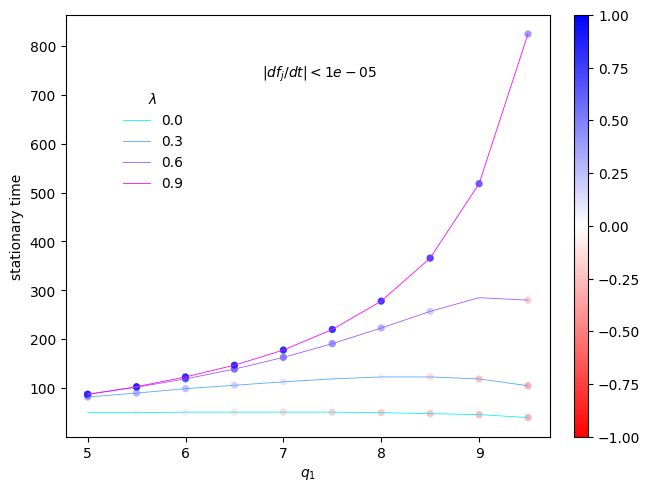

In [5]:
Nsites = 2
pi1, pi2, q2 = 0.1, 0.1, 10
q1s = [5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5]
ls = [0.0, 0.3, 0.6, 0.9]
ls_colors = plt.cm.cool(np.linspace(0.05, 0.95, len(ls)))
thresh = 1e-5


fig, ax = plt.subplots(constrained_layout=True)
ax.set(ylabel='stationary time', xlabel='$q_1$')
for l,lc in zip(ls, ls_colors):
    stat_times_fixl = []
    Qs_fixl = []
    for q1 in q1s:
        file = f'time_evo_csv_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_Euler.csv'
        if not os.path.exists(f'{getTimeEvosPath()}/{file}'):
            intEvo(pi1, pi2, q1, q2, l, 100, ic='N', bots_per_site=(100, 0, 0), max_time = 1000)
        # if q1 == 9.5:
        #     intEvo(pi1, pi2, q1, q2, l, 100, ic='N', bots_per_site=(100, 0, 0), max_time = 2000)
        df = pd.read_csv(f'{getTimeEvosPath()}/{file}')
        df_dt = evoTimeDeriv(df, Nsites)
        # fet stationar time for each fj:
        stat_times_fjs = [df['iter'][np.array(abs(df_dt[f'df{j}']) < thresh)].iloc[0] for j in range(Nsites+1)]
        stat_time = max(stat_times_fjs)
        stat_times_fixl.append(stat_time)
        Qs_fixl.append(df['f2'].iloc[stat_time] - 2*df['f1'].iloc[stat_time])
    ax.plot(q1s, stat_times_fixl, label=f'{l}', lw=0.6, color=lc)
    points = ax.scatter(q1s, stat_times_fixl, c=Qs_fixl, cmap='bwr_r', vmin=-1, vmax=1, marker='.', s=70)

cb = fig.colorbar(points, aspect=30, fraction=0.10)
fig.legend(title='$\lambda$', loc=(0.18, 0.6), frameon=False)
fig.text(0.4, 0.85, rf'$|df_j /dt| < {thresh}$')
fig.savefig(f'stat_times_Euler_varq1_q2_{q2}_pi1_{pi1}_pi2_{pi2}_many_l_thresh_{thresh}.png')

### l=0.9; exponential?

0.4035313515466788


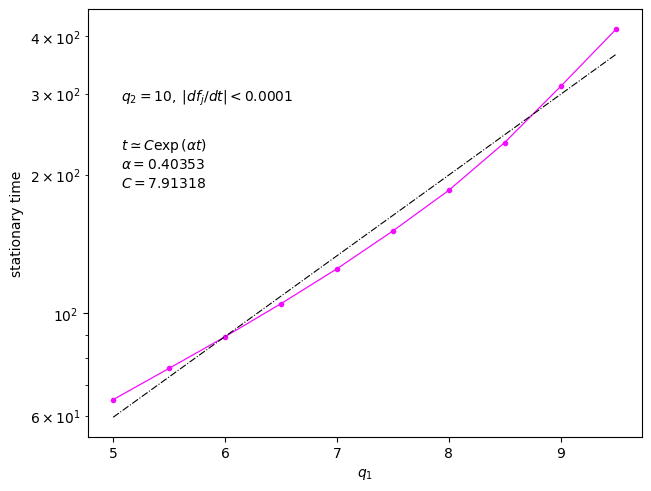

In [27]:
from scipy.stats import linregress
fig, ax = plt.subplots(constrained_layout=True)
pi1, pi2, q1, q2 = 0.1, 0.1, 9, 10
thresh = 1e-4
times = [65, 76, 89, 105, 125, 151, 185, 235, 311, 415] # times at l=0.9 and threshold 1e-4
ax.set(yscale='log', ylabel='stationary time', xlabel='$q_1$')
ax.plot(q1s, times, lw=0.9, marker='.', color=ls_colors[-1])
ln_times = np.log(np.array(times))
linParams = linregress(q1s, ln_times)
slope = linParams[0]
print(slope)
ax.plot(q1s, np.exp(slope*np.array(q1s)+linParams[1]), lw=0.8, ls='-.', color='xkcd:black')
fig.text(0.18, 0.8, rf'$q_2 = 10, \; |df_j /dt| < {thresh}$')
fig.text(0.18, 0.7, r'$t \simeq C \exp{(\alpha t)}$')
fig.text(0.18, 0.66, rf'$\alpha = {round(slope,5)}$')
fig.text(0.18, 0.62, rf'$C= {round(np.exp(linParams[1]),5)}$')
fig.savefig(f'stat_times_Euler_expoFit_q1_{q1}_q2_{q2}_pi1_{pi1}_pi2_{pi2}_l_{l}_thresh_{thresh}.png')


## Focusing on l=0.9, varying q1. Let's study the effect of pi:

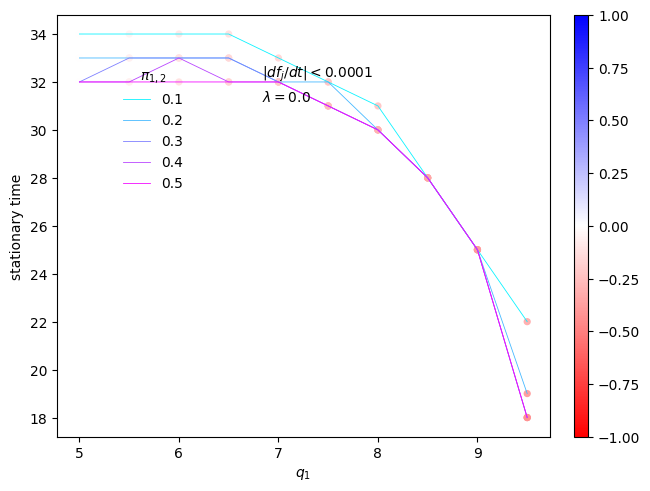

In [17]:
Nsites = 2
q2, l = 10, 0.0
q1s = [5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5]
pis = [0.1, 0.2, 0.3, 0.4, 0.5]
pis_colors = plt.cm.cool(np.linspace(0.05, 0.95, len(pis)))
thresh = 1e-4


fig, ax = plt.subplots(constrained_layout=True)
ax.set(ylabel='stationary time', xlabel='$q_1$')
for pi,pic in zip(pis, pis_colors):
    stat_times_fixPi = []
    Qs_fixPi = []
    for q1 in q1s:
        file = f'time_evo_csv_pi1_{pi}_pi2_{pi}_q1_{q1}_q2_{q2}_l_{l}_Euler.csv'
        if not os.path.exists(f'{getTimeEvosPath()}/{file}'):
            intEvo(pi, pi, q1, q2, l, 100, ic='N', bots_per_site=(100, 0, 0), max_time = 1000)
        df = pd.read_csv(f'{getTimeEvosPath()}/{file}')
        df_dt = evoTimeDeriv(df, Nsites)
        # fet stationar time for each fj:
        stat_times_fjs = [df['iter'][np.array(abs(df_dt[f'df{j}']) < thresh)].iloc[0] for j in range(Nsites+1)]
        stat_time = max(stat_times_fjs)
        stat_times_fixPi.append(stat_time)
        Qs_fixPi.append(df['f2'].iloc[stat_time] - 2*df['f1'].iloc[stat_time])
    ax.plot(q1s, stat_times_fixPi, label=f'{pi}', lw=0.6, color=pic)
    points = ax.scatter(q1s, stat_times_fixPi, c=Qs_fixPi, cmap='bwr_r', vmin=-1, vmax=1, marker='.', s=70)

cb = fig.colorbar(points, aspect=30, fraction=0.10)
fig.legend(title='$\pi_{1,2}$', loc=(0.18, 0.6), frameon=False)
fig.text(0.4, 0.85, rf'$|df_j /dt| < {thresh}$')
fig.text(0.4, 0.8, rf'$\lambda = {l}$')
fig.savefig(f'stat_times_Euler_varq1_q2_{q2}_l_{l}_many_pi12_thresh_{thresh}.png')